# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


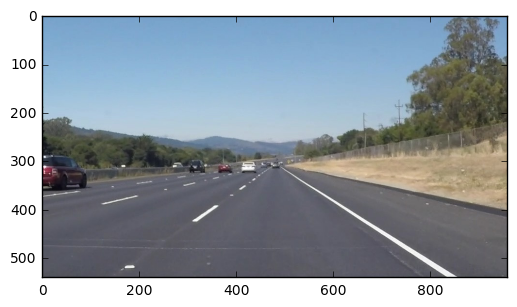

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, ρ, θ, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns hough lines.
    """
    lines = cv2.HoughLinesP(img, ρ, θ, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
class Pipeline(object):
    """
    Pipeline class to store previous frame states in a video. 
    By averaging successive frame lines, we achieve less jittery lane detection. 
    Depending on the framerate, we might want to look at more than
    one previous frame, but for the purposes of this exercise, one suffices.
    """
    def __init__(self):
        # Previous frame state
        self.previous_lines = None
        # Gaussian blur kernel size
        self.kernel_size = 5
        # Canny edge parameters
        self.low_threshold = 100
        self.high_threshold = 250
        # ROI vertices
        self.vertices = np.array([[(0,540),(450, 320),(490, 320),(980,540)]], dtype=np.int32)
        # Hough line parameters
        self.ρ = 1.5                 # distance resolution in pixels of the Hough grid
        self.θ = np.pi/720           # angular resolution in radians of the Hough grid
        self.threshold = 50          # minimum number of votes (intersections in Hough grid cell)
        self.min_line_len = 10       # minimum number of pixels making up a line
        self.max_line_gap = 200      # maximum gap in pixels between connectable line segments
    
    def draw_lane(self, img, segments, color=[255, 0, 0], thickness=2):
        """
        Computes the lane lines based on a set of hough segments.
        """
        # Consider the line equation of the form y=mx+b.
        # Store the 'm' and 'b' parameters of all segments
        lane_img = np.zeros_like(img)
        segment_params = np.zeros((len(segments), 2))
        for si, segment in enumerate(segments):
            for x1,y1,x2,y2 in segment:
                m = (y2-y1)/(x2-x1)
                b = (y1-m*x1)
                segment_params[si,:] = np.array([m, b])

        # Segment is "outlier" if slope is near horizontal (this condition could be improved).
        is_outlier = np.abs(segment_params[:,0]) < 0.2
        segment_params = segment_params[~is_outlier]
        # Segment is part of left line if its slope is positive, vice-versa.
        is_left = segment_params[:,0] > 0
        left_params = segment_params[is_left]
        right_params = segment_params[~is_left]

        # Average the parameters
        left_line = np.average(left_params, axis=0)
        right_line = np.average(right_params, axis=0)
        # Now, average current lines with previous lines, if the latter exists.
        if self.previous_lines is not None:
            left_line = np.average(np.vstack((left_line, self.previous_lines[0,:])), axis=0)
            right_line = np.average(np.vstack((right_line, self.previous_lines[1,:])), axis=0)

        # Extrapolate end points from equation parameters.
        # The endpoints are located at the y-bounds of the ROI.
        for line in [left_line, right_line]:
            if np.isnan(line[0]) or np.isinf(line[0]):
                continue
            x1, y1 = int((540-line[1])/line[0]), 540
            x2, y2 = int((330-line[1])/line[0]), 330
            cv2.line(lane_img, (x1, y1), (x2, y2), color, thickness)

        # Store current frame lines.
        self.previous_lines = np.vstack((left_line, right_line))

        return lane_img
        
    def process_image(self, img):
        """
        Detect lane lines in `img`.
        """
        # Get image grayscale.
        gray = grayscale(img)
        # Apply Gaussian smoothing.
        blur = gaussian_blur(img, self.kernel_size)
        
        # Extract Canny edges.
        edges = canny(blur, self.low_threshold, self.high_threshold)
        # Define the region of interest.
        masked_img = region_of_interest(edges, self.vertices)
        # Compute hough lines
        lines = hough_lines(masked_img, self.ρ, self.θ, self.threshold, self.min_line_len, self.max_line_gap)
        
        # Extrapolate lane image
        lane_img = self.draw_lane(img, lines, color=[255, 0, 0], thickness=12)
        overlay_img = weighted_img(lane_img, img, α=0.8, β=0.8, λ=0.)

        return overlay_img

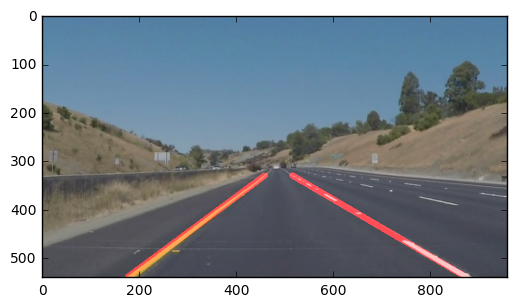

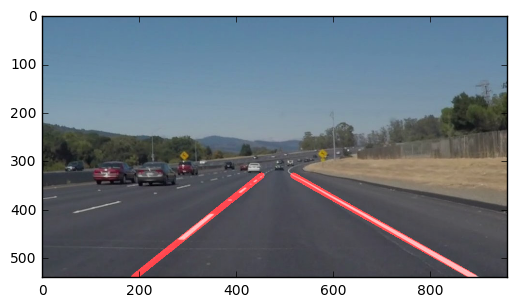

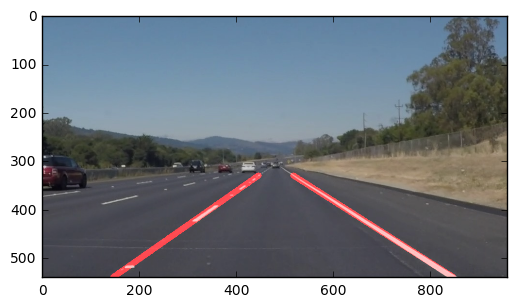

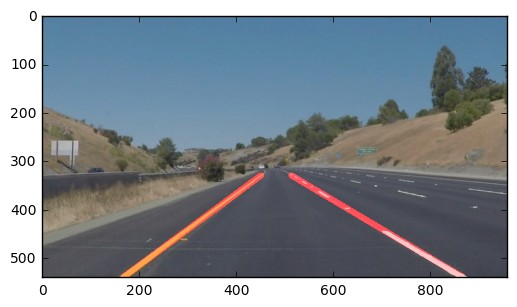

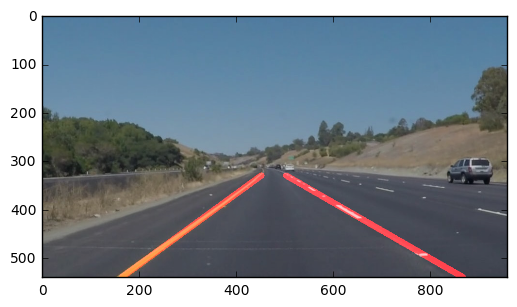

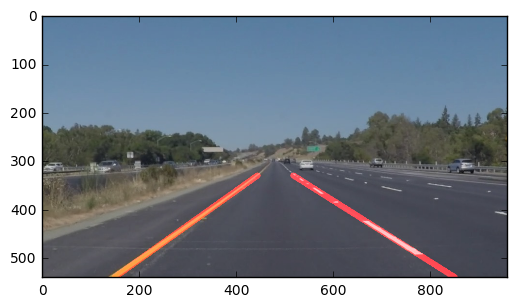

In [5]:
import os
# Read each image file and run it through the pipeline
images = [ mpimg.imread("test_images/%s" % filename) for filename in os.listdir("test_images/") ]
for ii, image in enumerate(images):
    fig = plt.figure()
    pipe = Pipeline()
    lane_img = pipe.process_image(image)
    plt.imshow(lane_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
pipe = Pipeline()
white_clip = clip1.fl_image(pipe.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:07<00:00, 29.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 55.2 s, sys: 464 ms, total: 55.7 s
Wall time: 8.42 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
pipe = Pipeline()
yellow_clip = clip2.fl_image(pipe.process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:27<00:00, 24.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 7s, sys: 1.39 s, total: 3min 8s
Wall time: 28.3 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


**Answer**:

The lane detection pipeline above is designed for clear daylight conditions, with a camera mounted to the front of the car, producing video/image of the given size. It also assumes that the lane lines are clear and contrast well with the road. Another requirement is that the lanes be relatively straight.

In the challenge below, the camera is mounted differently, which leads to the current ROI being inadequate. Moreover, the lane is turning, so the ROI we've defined looks too far ahead to properly detect lines (since the lane lines are now curved). Furthermore, to improve on the current pipeline, the outlier detection I've implemented should be extended; simply rejecting near-horizontal hough segments isn't enough.

I could go on, there is a virtually infinite number of ways the pipeline could fail, and so understanding the assumptions of the algorithm is primordial. The world's roads are highly unpredictable, and I'm sure we'll be building on top of this simple lane detection pipeline to increase the safety factor and robustness of the system as a whole.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))